In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import pickle

In [2]:
# Конфигурационные параметры
EMBEDDING_SIZE = 256  # Размер выходного эмбеддинга
IMAGE_SIZE = 224      # Размер изображения для ResNet
BATCH_SIZE = 32       # Размер батча для обработки

# Путь к папке с данными
DATA_PATH = 'images_train'

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class EmbeddingExtractor(nn.Module):
    def __init__(self, embedding_size):
        super(EmbeddingExtractor, self).__init__()
        # Загрузка предобученной ResNet50
        self.resnet = models.resnet50(pretrained=True)
        # Удаляем последний полносвязный слой
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        # Добавляем свой полносвязный слой для получения нужного размера эмбеддинга
        self.fc = nn.Linear(2048, embedding_size)
        
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # Разворачиваем в вектор
        x = self.fc(x)
        return x

In [4]:
# Трансформации для изображений
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img = transform(img)
                images.append(img)
            except:
                print(f'Error loading image {img_path}')
    return torch.stack(images)

In [6]:
def extract_embeddings(model_folders):
    model = EmbeddingExtractor(EMBEDDING_SIZE).to(device)
    model.eval()
    
    all_embeddings = []
    model_labels = []
    
    with torch.no_grad():
        for model_idx, folder in enumerate(model_folders):
            images = load_images_from_folder(folder)
            # Обрабатываем батчами для экономии памяти
            for i in range(0, len(images), BATCH_SIZE):
                batch = images[i:i+BATCH_SIZE].to(device)
                embeddings = model(batch)
                all_embeddings.append(embeddings.cpu().numpy())
                model_labels.extend([model_idx] * len(embeddings))
    
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    return all_embeddings, np.array(model_labels)

In [7]:
def normalize_embeddings(embeddings):
    scaler = StandardScaler()
    return scaler.fit_transform(embeddings)

def cluster_embeddings(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    return clusters, kmeans.cluster_centers_

In [8]:
def ensure_cluster_separation(embeddings, clusters, centers, min_distance=5.0):
    """
    Гарантирует, что кластеры не находятся слишком близко друг к другу.
    Если кластеры слишком близки, перемещает их центры.
    """
    distances = euclidean_distances(centers)
    np.fill_diagonal(distances, np.inf)  # Игнорируем расстояние между одним и тем же кластером
    
    too_close = distances < min_distance
    while np.any(too_close):
        for i in range(len(centers)):
            for j in range(i+1, len(centers)):
                if distances[i, j] < min_distance:
                    # Перемещаем центры кластеров дальше друг от друга
                    direction = centers[i] - centers[j]
                    direction = direction / np.linalg.norm(direction)
                    centers[i] += direction * (min_distance - distances[i, j]) / 2
                    centers[j] -= direction * (min_distance - distances[i, j]) / 2
        
        distances = euclidean_distances(centers)
        np.fill_diagonal(distances, np.inf)
        too_close = distances < min_distance
    
    # Пересчитываем кластеры с новыми центрами
    new_clusters = []
    for emb in embeddings:
        dists = [np.linalg.norm(emb - center) for center in centers]
        new_clusters.append(np.argmin(dists))
    
    return np.array(new_clusters), centers

In [9]:
def visualize_clusters(embeddings_2d, clusters, model_labels):
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, 
                         cmap='tab20', alpha=0.6, edgecolors='w', linewidth=0.5)
    
    # Добавляем настоящие метки моделей для проверки
    for i, txt in enumerate(model_labels):
        plt.annotate(txt, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                     fontsize=8, alpha=0.5)
    
    plt.colorbar(scatter)
    plt.title('Cluster Visualization with Model Labels')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

In [10]:
import random
from matplotlib import gridspec

def visualize_neighbors(embeddings, model_folders, n_samples=3, k_neighbors=5):
    """
    Визуализирует n случайных изображений и их k ближайших соседей в embedding-пространстве
    
    Args:
        embeddings: нормализованные эмбеддинги всех изображений
        model_folders: список путей к папкам с моделями
        n_samples: количество случайных изображений для анализа
        k_neighbors: количество ближайших соседей
    """
    # Собираем все изображения и их пути
    all_images = []
    image_paths = []
    
    for folder in model_folders:
        for filename in sorted(os.listdir(folder)):
            if filename.endswith('.png'):
                img_path = os.path.join(folder, filename)
                all_images.append(Image.open(img_path).convert('RGB'))
                image_paths.append(img_path)
    
    # Выбираем случайные индексы
    sample_indices = random.sample(range(len(embeddings)), n_samples)
    
    # Вычисляем попарные расстояния между всеми эмбеддингами
    distances = euclidean_distances(embeddings)
    
    for idx in sample_indices:
        # Находим k ближайших соседей (исключая само изображение)
        neighbors = np.argsort(distances[idx])[1:k_neighbors+1]
        
        # Создаем фигуру для отображения
        plt.figure(figsize=(15, 3))
        gs = gridspec.GridSpec(1, k_neighbors+1, width_ratios=[1.2] + [1]*k_neighbors)
        
        # Отображаем исходное изображение
        plt.subplot(gs[0])
        plt.imshow(all_images[idx])
        plt.title(f"Query\n{os.path.basename(image_paths[idx])}")
        plt.axis('off')
        
        # Отображаем соседей
        for i, neighbor_idx in enumerate(neighbors, 1):
            plt.subplot(gs[i])
            plt.imshow(all_images[neighbor_idx])
            dist = distances[idx, neighbor_idx]
            plt.title(f"Dist: {dist:.2f}\n{os.path.basename(image_paths[neighbor_idx])}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

Found 10 model folders


D:\ANACONDA\envs\aiijc_2025\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\ANACONDA\envs\aiijc_2025\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracted embeddings shape: (260, 256)
Embeddings normalized


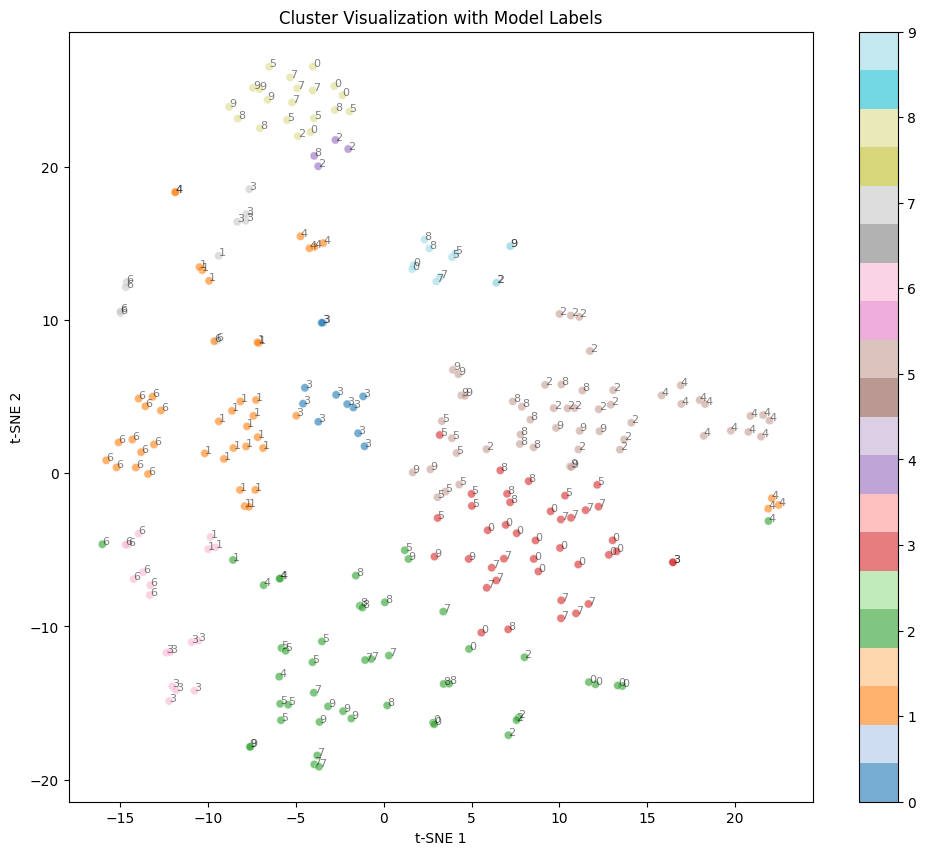

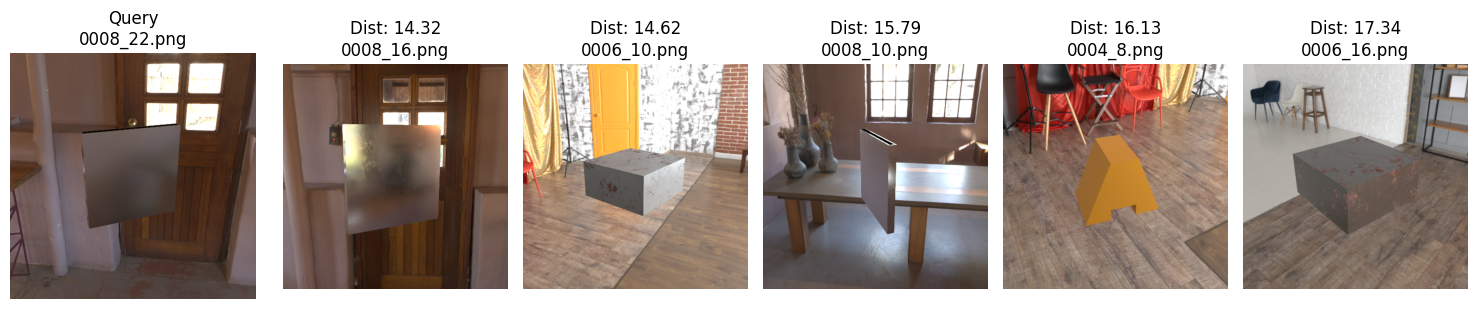

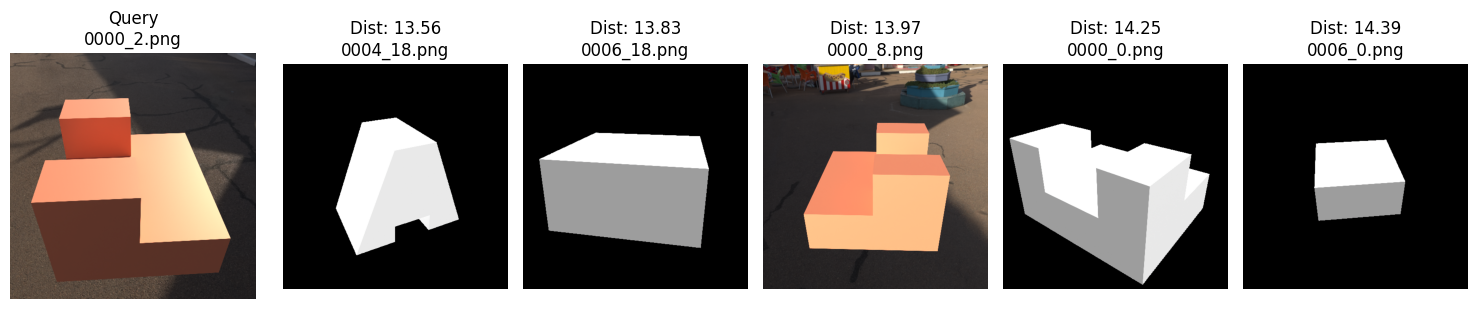

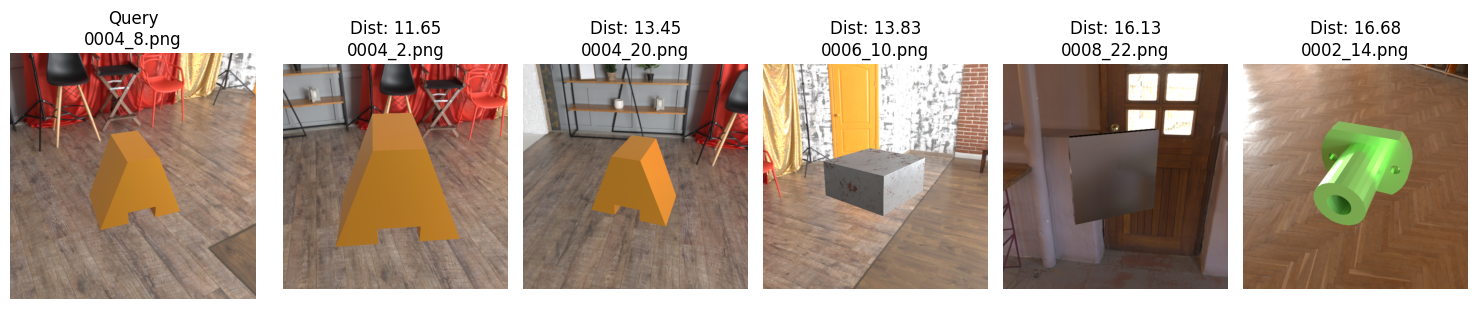

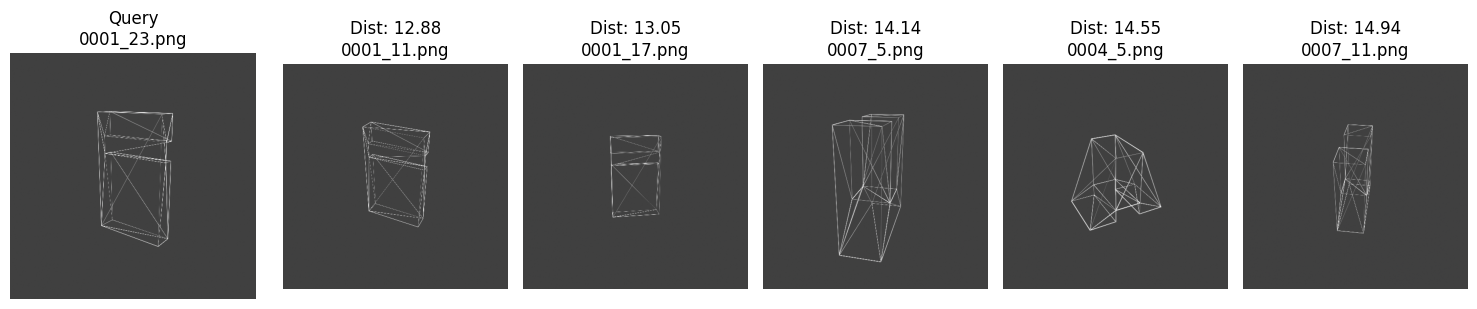

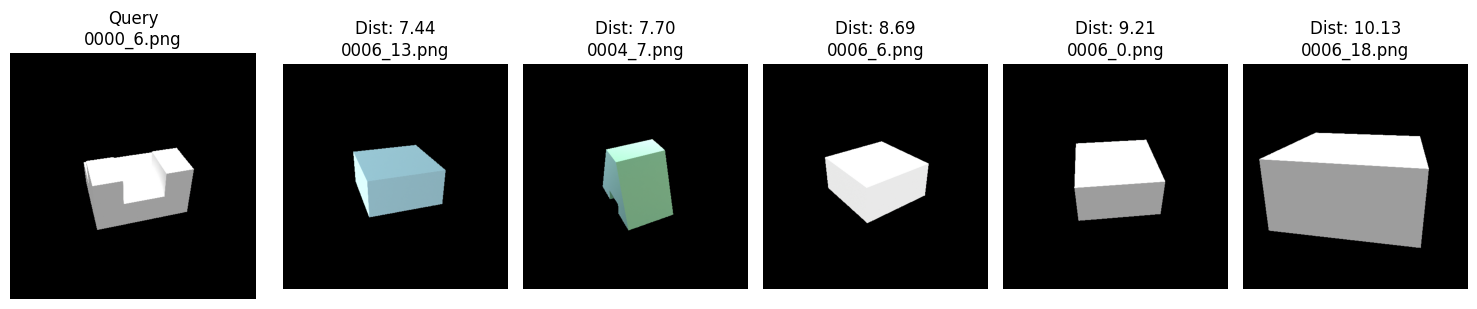

Results saved to disk


In [11]:
# Получаем список папок с моделями
model_folders = [os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH) 
                if os.path.isdir(os.path.join(DATA_PATH, f))]
model_folders.sort()
    
print(f"Found {len(model_folders)} model folders")
    
# Извлекаем эмбеддинги
embeddings, model_labels = extract_embeddings(model_folders)
print(f"Extracted embeddings shape: {embeddings.shape}")
    
# Нормализуем эмбеддинги
normalized_embeddings = normalize_embeddings(embeddings)
print("Embeddings normalized")
    
# Кластеризация (количество кластеров = количеству моделей)
n_clusters = len(model_folders)
clusters, centers = cluster_embeddings(normalized_embeddings, n_clusters)
    
# Гарантируем разделение кластеров
separated_clusters, separated_centers = ensure_cluster_separation(
    normalized_embeddings, clusters, centers)
    
# Визуализация с помощью t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(normalized_embeddings)
    
visualize_clusters(embeddings_2d, separated_clusters, model_labels)
visualize_neighbors(normalized_embeddings, model_folders, n_samples=5, k_neighbors=5)
    
    
# Сохраняем результаты
np.save('model_embeddings.npy', normalized_embeddings)
np.save('model_labels.npy', model_labels)
np.save('cluster_labels.npy', separated_clusters)
print("Results saved to disk")

Using device: cpu
Found 10 model folders


D:\ANACONDA\envs\aiijc_2025\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\ANACONDA\envs\aiijc_2025\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracted embeddings shape: (260, 256)
Embeddings normalized


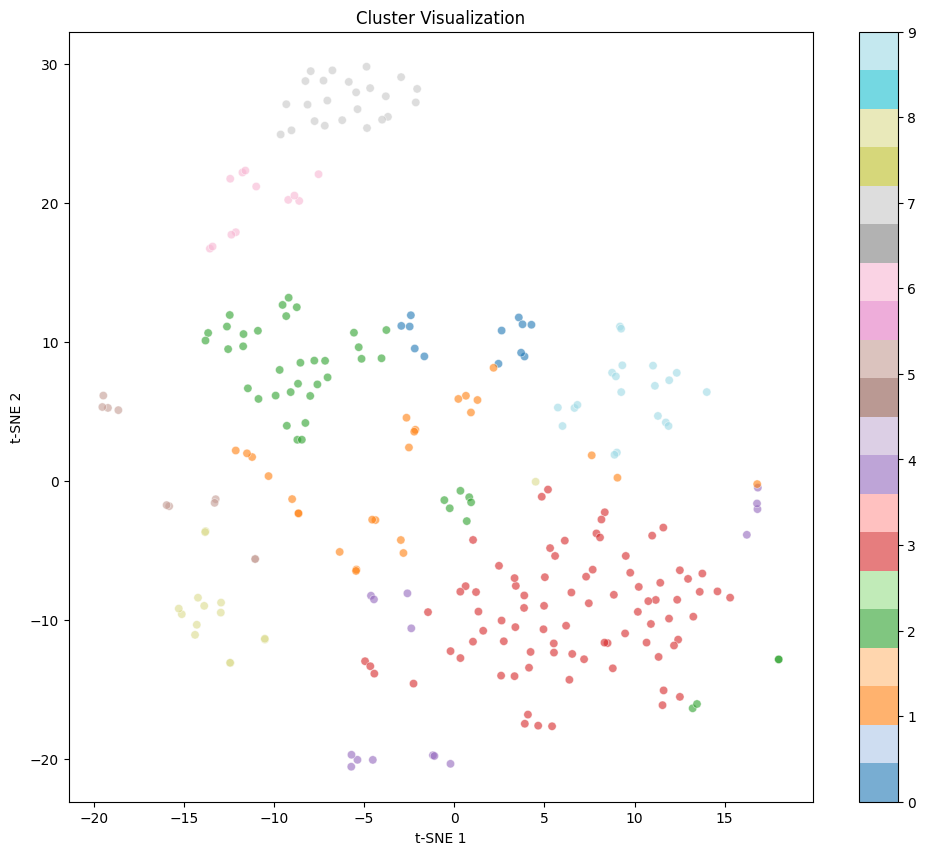

Epoch 1/50, Loss: 0.4875
Epoch 2/50, Loss: 0.4687
Epoch 3/50, Loss: 0.4370
Epoch 4/50, Loss: 0.4509
Epoch 5/50, Loss: 0.3885
Epoch 6/50, Loss: 0.3693
Epoch 7/50, Loss: 0.3953
Epoch 8/50, Loss: 0.4095
Epoch 9/50, Loss: 0.4643
Epoch 10/50, Loss: 0.4691
Epoch 11/50, Loss: 0.4537
Epoch 12/50, Loss: 0.5102
Epoch 13/50, Loss: 0.3621
Epoch 14/50, Loss: 0.4092
Epoch 15/50, Loss: 0.4578
Epoch 16/50, Loss: 0.4136
Epoch 17/50, Loss: 0.4520
Epoch 18/50, Loss: 0.4908
Epoch 19/50, Loss: 0.4240
Epoch 20/50, Loss: 0.3920
Epoch 21/50, Loss: 0.4148
Epoch 22/50, Loss: 0.4087
Epoch 23/50, Loss: 0.4292
Epoch 24/50, Loss: 0.4393
Epoch 25/50, Loss: 0.3780
Epoch 26/50, Loss: 0.3912
Epoch 27/50, Loss: 0.4055
Epoch 28/50, Loss: 0.4268
Epoch 29/50, Loss: 0.4788
Epoch 30/50, Loss: 0.3895
Epoch 31/50, Loss: 0.3924
Epoch 32/50, Loss: 0.3580
Epoch 33/50, Loss: 0.3703
Epoch 34/50, Loss: 0.4026
Epoch 35/50, Loss: 0.3586
Epoch 36/50, Loss: 0.4081
Epoch 37/50, Loss: 0.4012
Epoch 38/50, Loss: 0.3724
Epoch 39/50, Loss: 0.

In [13]:
# %% [markdown]
# # Обучение совместных эмбеддингов для изображений и STL-моделей
# 
# Этот ноутбук:
# 1. Извлекает эмбеддинги изображений с помощью ResNet
# 2. Кластеризует эмбеддинги изображений
# 3. Обучает PointNet генерировать эмбеддинги STL-моделей, близкие к центрам соответствующих кластеров

# %%
# Импорт всех необходимых библиотек
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import trimesh
from torch.utils.data import Dataset, DataLoader

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# %% [markdown]
# ## Часть 1: Извлечение эмбеддингов изображений

# %%
# Конфигурационные параметры
EMBEDDING_SIZE = 256  # Размер выходного эмбеддинга
IMAGE_SIZE = 224      # Размер изображения для ResNet
BATCH_SIZE = 32       # Размер батча для обработки
DATA_PATH = 'images_train'  # Путь к папке с изображениями

# %%
class EmbeddingExtractor(nn.Module):
    def __init__(self, embedding_size):
        super(EmbeddingExtractor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        self.fc = nn.Linear(2048, embedding_size)
        
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# %%
# Трансформации для изображений
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# %%
def load_images_from_folder(folder):
    """Загрузка изображений из папки"""
    images = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img = transform(img)
                images.append(img)
            except:
                print(f'Error loading image {img_path}')
    return torch.stack(images)

# %%
def extract_embeddings(model_folders):
    """Извлечение эмбеддингов для всех изображений"""
    model = EmbeddingExtractor(EMBEDDING_SIZE).to(device)
    model.eval()
    
    all_embeddings = []
    model_labels = []
    
    with torch.no_grad():
        for model_idx, folder in enumerate(model_folders):
            images = load_images_from_folder(folder)
            for i in range(0, len(images), BATCH_SIZE):
                batch = images[i:i+BATCH_SIZE].to(device)
                embeddings = model(batch)
                all_embeddings.append(embeddings.cpu().numpy())
                model_labels.extend([model_idx] * len(embeddings))
    
    return np.concatenate(all_embeddings, axis=0), np.array(model_labels)

# %%
# Получаем список папок с моделями
model_folders = [os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH) 
                if os.path.isdir(os.path.join(DATA_PATH, f))]
model_folders.sort()
    
print(f"Found {len(model_folders)} model folders")

# %%
# Извлекаем эмбеддинги
embeddings, model_labels = extract_embeddings(model_folders)
print(f"Extracted embeddings shape: {embeddings.shape}")

# %%
# Нормализуем эмбеддинги
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings)
print("Embeddings normalized")

# %% [markdown]
# ## Часть 2: Кластеризация изображений

# %%
def cluster_embeddings(embeddings, n_clusters):
    """Кластеризация эмбеддингов с помощью K-means"""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    return clusters, kmeans.cluster_centers_

# %%
def ensure_cluster_separation(embeddings, clusters, centers, min_distance=5.0):
    """Гарантирует минимальное расстояние между центрами кластеров"""
    distances = euclidean_distances(centers)
    np.fill_diagonal(distances, np.inf)
    
    too_close = distances < min_distance
    while np.any(too_close):
        for i in range(len(centers)):
            for j in range(i+1, len(centers)):
                if distances[i, j] < min_distance:
                    direction = centers[i] - centers[j]
                    direction = direction / np.linalg.norm(direction)
                    centers[i] += direction * (min_distance - distances[i, j]) / 2
                    centers[j] -= direction * (min_distance - distances[i, j]) / 2
        
        distances = euclidean_distances(centers)
        np.fill_diagonal(distances, np.inf)
        too_close = distances < min_distance
    
    # Пересчитываем кластеры с новыми центрами
    new_clusters = []
    for emb in embeddings:
        dists = [np.linalg.norm(emb - center) for center in centers]
        new_clusters.append(np.argmin(dists))
    
    return np.array(new_clusters), centers

# %%
# Кластеризация (количество кластеров = количеству моделей)
n_clusters = len(model_folders)
clusters, centers = cluster_embeddings(normalized_embeddings, n_clusters)
    
# Гарантируем разделение кластеров
separated_clusters, separated_centers = ensure_cluster_separation(
    normalized_embeddings, clusters, centers)

# %%
# Визуализация с помощью t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(normalized_embeddings)

plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=separated_clusters, 
            cmap='tab20', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.colorbar()
plt.title('Cluster Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# %% [markdown]
# ## Часть 3: Обучение PointNet на STL-файлах

# %%
# Определяем модель PointNet
class STN3d(nn.Module):
    """Пространственное преобразование для PointNet"""
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        iden = torch.eye(3).flatten().view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

class PointNetCls(nn.Module):
    """PointNet для классификации/эмбеддингов"""
    def __init__(self, k=2):
        super(PointNetCls, self).__init__()
        self.stn = STN3d()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.relu = nn.ReLU()

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.conv1(x))
        
        pointfeat = x
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x, trans, pointfeat

# %%
class STLDataset(Dataset):
    """Датасет для загрузки STL-файлов и соответствующих центров кластеров"""
    def __init__(self, stl_dir, cluster_centers):
        self.stl_files = [os.path.join(stl_dir, f) for f in os.listdir(stl_dir) if f.endswith('.stl')]
        self.stl_files.sort()
        self.cluster_centers = cluster_centers
        
    def __len__(self):
        return len(self.stl_files)
    
    def __getitem__(self, idx):
        # Загрузка STL-файла и преобразование в облако точек
        mesh = trimesh.load(self.stl_files[idx])
        points = mesh.sample(1024)  # Выбираем 1024 точки
        
        # Нормализация точек
        points = self.normalize_points(points)
        
        # Получаем соответствующий центр кластера
        target_embedding = self.cluster_centers[idx]
        
        return torch.FloatTensor(points), torch.FloatTensor(target_embedding)
    
    def normalize_points(self, points):
        """Нормализация облака точек к единичной сфере"""
        centroid = np.mean(points, axis=0)
        points -= centroid
        furthest_distance = np.max(np.sqrt(np.sum(abs(points)**2, axis=-1)))
        points /= furthest_distance
        return points

# %%
def train_pointnet(stl_dir, cluster_centers, epochs=50):
    """Обучение PointNet для генерации эмбеддингов"""
    # Инициализация модели
    pointnet = PointNetCls(k=EMBEDDING_SIZE).to(device)
    optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Создание датасета
    dataset = STLDataset(stl_dir, cluster_centers)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    # Цикл обучения
    pointnet.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (points, target_embeddings) in enumerate(dataloader):
            points = points.transpose(2, 1).to(device)
            target_embeddings = target_embeddings.to(device)
            
            optimizer.zero_grad()
            pred_embeddings, _, _ = pointnet(points)
            loss = criterion(pred_embeddings, target_embeddings)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}')
    
    return pointnet

# %%
# Путь к папке с STL-файлами
STL_DIR = 'stl_dir'

# Обучаем PointNet
pointnet = train_pointnet(STL_DIR, separated_centers)

# Сохраняем модель
torch.save(pointnet.state_dict(), 'pointnet_embedding.pth')
print("PointNet model trained and saved")

# %% [markdown]
# ## Сохранение всех результатов

# %%
# Сохраняем эмбеддинги и метки
np.save('model_embeddings.npy', normalized_embeddings)
np.save('model_labels.npy', model_labels)
np.save('cluster_labels.npy', separated_clusters)
np.save('cluster_centers.npy', separated_centers)
print("All results saved to disk")

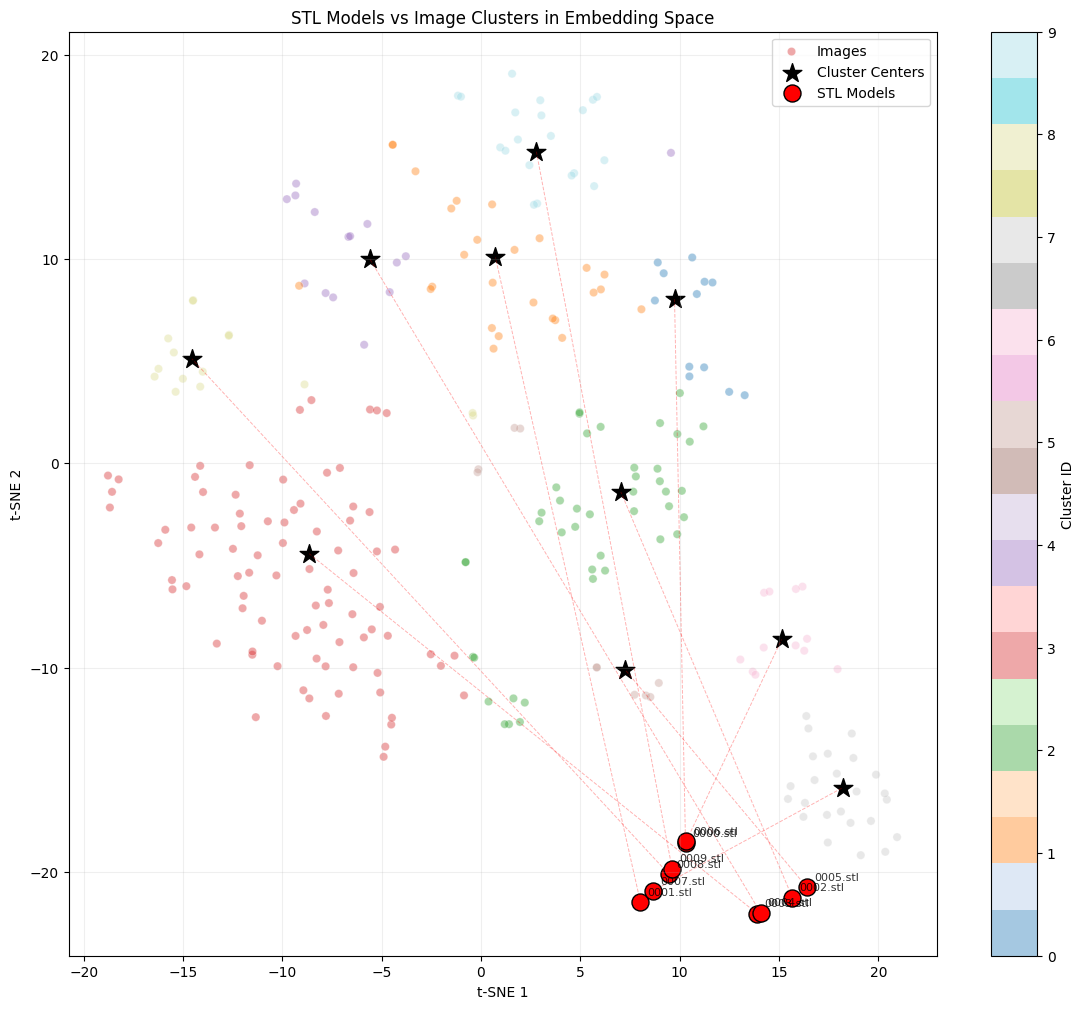

In [14]:
# %% [markdown]
# ## Визуализация STL-файлов относительно кластеров изображений

# %%
def visualize_stl_embeddings(pointnet, stl_dir, image_embeddings, cluster_centers, separated_clusters):
    """
    Визуализирует:
    1. Эмбеддинги изображений (цвета - кластеры)
    2. Центры кластеров (черные звезды)
    3. Эмбеддинги STL-файлов (красные точки)
    """
    # Получаем эмбеддинги для всех STL-файлов
    stl_files = [os.path.join(stl_dir, f) for f in os.listdir(stl_dir) if f.endswith('.stl')]
    stl_files.sort()
    
    pointnet.eval()
    stl_embeddings = []
    
    with torch.no_grad():
        for stl_file in stl_files:
            mesh = trimesh.load(stl_file)
            points = mesh.sample(1024)
            points = torch.FloatTensor(points).unsqueeze(0).transpose(2, 1).to(device)
            emb, _, _ = pointnet(points)
            stl_embeddings.append(emb.cpu().numpy())
    
    stl_embeddings = np.concatenate(stl_embeddings, axis=0)
    
    # Применяем t-SNE ко всем данным
    combined_embeddings = np.concatenate([image_embeddings, cluster_centers, stl_embeddings], axis=0)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(combined_embeddings)
    
    # Разделяем обратно
    n_images = len(image_embeddings)
    n_centers = len(cluster_centers)
    image_2d = embeddings_2d[:n_images]
    centers_2d = embeddings_2d[n_images:n_images+n_centers]
    stl_2d = embeddings_2d[n_images+n_centers:]
    
    # Визуализация
    plt.figure(figsize=(14, 12))
    
    # 1. Изображения (цвета - кластеры)
    scatter = plt.scatter(image_2d[:, 0], image_2d[:, 1], 
                         c=separated_clusters, cmap='tab20',
                         alpha=0.4, edgecolors='w', linewidth=0.5,
                         label='Images')
    
    # 2. Центры кластеров (черные звезды)
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1],
                marker='*', s=200, c='black',
                label='Cluster Centers')
    
    # 3. STL-файлы (красные точки)
    plt.scatter(stl_2d[:, 0], stl_2d[:, 1],
                marker='o', s=150, c='red',
                edgecolors='black', linewidth=1,
                label='STL Models')
    
    # Добавляем линии от STL-файлов к их центрам кластеров
    for i in range(len(stl_2d)):
        plt.plot([stl_2d[i, 0], centers_2d[i, 0]],
                 [stl_2d[i, 1], centers_2d[i, 1]],
                 'r--', alpha=0.3, linewidth=0.7)
    
    # Подписи для STL-файлов
    for i, stl_file in enumerate(stl_files):
        plt.annotate(os.path.basename(stl_file), 
                     (stl_2d[i, 0], stl_2d[i, 1]),
                     textcoords="offset points",
                     xytext=(5,5), ha='left',
                     fontsize=8, alpha=0.8)
    
    plt.colorbar(scatter, label='Cluster ID')
    plt.legend()
    plt.title('STL Models vs Image Clusters in Embedding Space')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.grid(alpha=0.2)
    plt.show()

# %%
# Вызываем функцию визуализации
visualize_stl_embeddings(pointnet, STL_DIR, normalized_embeddings, separated_centers, separated_clusters)